In [1]:
import sympy as sym
import numpy as np
from scipy import integrate

import math

from sympy.functions import Heaviside, sin, cos, sqrt
sym.init_printing()

import matplotlib.pyplot as plt
#from sympy.vector import *
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct,Dagger


import qutip
# This IPython magic generates a table with version information
#https://github.com/jrjohansson/version_information
#%load_ext version_information
%load_ext cython

In [2]:
def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)


def spost(m):
    return TensorProduct(m.T,sym.eye(m.shape[0]))

def collapse(c):
    temp = Dagger(c)*c
    return 2*spre(c)*spost(Dagger(c))-spre(temp)-spost(temp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13



### Checking spre and spost agree with qutip

Note: This notebook uses Frotran (colum first) order when flattening matricies.

In [3]:
sigmay = Matrix([[0, -I], [I, 0 ]])
sigmay, qutip.sigmay()

(Matrix([
 [0, -I],
 [I,  0]]),
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]])

In [4]:
qutip.sigmay()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

In [5]:
spre(sigmay),qutip.spre(qutip.sigmay())

(Matrix([
 [0, -I, 0,  0],
 [I,  0, 0,  0],
 [0,  0, 0, -I],
 [0,  0, I,  0]]),
 Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
  [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
  [0.+0.j 0.+0.j 0.+1.j 0.+0.j]])

In [6]:
spost(sigmay),qutip.spost(qutip.sigmay())

(Matrix([
 [ 0,  0, I, 0],
 [ 0,  0, 0, I],
 [-I,  0, 0, 0],
 [ 0, -I, 0, 0]]),
 Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
 Qobj data =
 [[0.+0.j 0.+0.j 0.+1.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+1.j]
  [0.-1.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.-1.j 0.+0.j 0.+0.j]])

In [7]:
delta2,delta3 = sym.symbols('delta_2 delta_3',real=True)
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu = sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False)
omegao,omegam = sym.symbols('Omega_o Omega_mu', real=True, negative=False)
a = sym.symbols('a')
ar,ai = sym.symbols('a_r a_i',real=True)

g = sym.symbols('g',real=True, negative=False)


In [8]:
H =  omegam*s21 + omegao*s32 + g*a*s31
H = H + Dagger(H)
H = H + delta2*s22 + delta3*s33
LH = -I*spre(H)+I*spost(H) 

L21 = gammamu/2*(nbath+1)*collapse(s12)
L12 = gammamu/2*(nbath)*collapse(s21)
L32 = gamma23/2*collapse(s23)
L31 = gamma13/2*collapse(s13)
L22 = gamma2d/2*collapse(s22)
L33 = gamma3d/2*collapse(s33)

L = LH + L21 + L12 + L32 + L31 + L22 + L33

#becausetrace rho = 1 we can replace first row
L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
L.row_del(1)

L

⎡   1                       0                                     0           
⎢                                                                             
⎢                 γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                              
⎢-ⅈ⋅Ωₘᵤ   -ⅈ⋅δ₂ - ──── - ─────── - ─────────────                -ⅈ⋅Ωₒ         
⎢                  2        2            2                                    
⎢                                                                             
⎢                                                         γ₁₃   γ₂₃   γ_3d   γ
⎢-ⅈ⋅a⋅g                   -ⅈ⋅Ωₒ                   -ⅈ⋅δ₃ - ─── - ─── - ──── - ─
⎢                                                          2     2     2      
⎢                                                                             
⎢                                                                             
⎢ ⅈ⋅Ωₘᵤ                     0                                     0           
⎢                                                   

In [9]:
H

⎡            _⎤
⎢ 0   Ωₘᵤ  g⋅a⎥
⎢             ⎥
⎢Ωₘᵤ  δ₂   Ωₒ ⎥
⎢             ⎥
⎣a⋅g  Ωₒ   δ₃ ⎦

In [10]:
L[:,0:3] #because the matrix gets clipped when exporting to PDF

⎡   1                       0                                     0           
⎢                                                                             
⎢                 γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                              
⎢-ⅈ⋅Ωₘᵤ   -ⅈ⋅δ₂ - ──── - ─────── - ─────────────                -ⅈ⋅Ωₒ         
⎢                  2        2            2                                    
⎢                                                                             
⎢                                                         γ₁₃   γ₂₃   γ_3d   γ
⎢-ⅈ⋅a⋅g                   -ⅈ⋅Ωₒ                   -ⅈ⋅δ₃ - ─── - ─── - ──── - ─
⎢                                                          2     2     2      
⎢                                                                             
⎢ ⅈ⋅Ωₘᵤ                     0                                     0           
⎢                                                                             
⎢γₘᵤ⋅n_b                  ⅈ⋅Ωₘᵤ                     

In [11]:
L[:,3:6]

⎡                  0                          1                               
⎢                                                                             
⎢                  0                        ⅈ⋅Ωₘᵤ                             
⎢                                                                             
⎢                  0                          0                               
⎢                                                                             
⎢       γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                                        
⎢ⅈ⋅δ₂ - ──── - ─────── - ─────────────      -ⅈ⋅Ωₘᵤ                            
⎢        2        2            2                                              
⎢                                                                             
⎢               -ⅈ⋅Ωₘᵤ                  -γₘᵤ⋅(n_b + 1)                        
⎢                                                                             
⎢                                                   

In [12]:
L[:,6:]

⎡                0                                            0               
⎢                                                                             
⎢                0                                          ⅈ⋅a⋅g             
⎢                                                                             
⎢                0                                            0               
⎢                                                                             
⎢              ⅈ⋅Ωₒ                                           0               
⎢                                                                             
⎢                0                                           ⅈ⋅Ωₒ             
⎢                                                                             
⎢                0                                            0               
⎢                                                                             
⎢       γ₁₃   γ₂₃   γ_3d   γₘᵤ⋅n_b                  

In [13]:
rho11,rho12,rho13,rho21,rho22,rho23,rho31,rho32,rho33 = sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33')
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]
rhoflat[6]

In [14]:
#change of variables to make things real to make it a bit faster maybe
CtoR = Matrix([[2,0,0,0,0,0,0,0,0],
               [0,0,0,0,2,0,0,0,0],
               [0,0,0,0,0,0,0,0,2],
               [0,1,0,1,0,0,0,0,0],
               [0,I,0,-I,0,0,0,0,0],
               [0,0,1,0,0,0,1,0,0],
               [0,0,I,0,0,0,-I,0,0],
               [0,0,0,0,0,1,0,1,0],
               [0,0,0,0,0,I,0,-I,0]
              ])
CtoR=CtoR/2

In [15]:
#these is our new state vector 
t = CtoR*Matrix(rhoflat)
t[5:7]

In [16]:
Lreal = sym.simplify(CtoR*L*CtoR.inv())
Lreal = Lreal.subs(a,ar+I*ai)
Lreal

⎡   1           1             1                 0                       0     
⎢                                                                             
⎢γₘᵤ⋅n_b  -γₘᵤ⋅(n_b + 1)     γ₂₃                0                     2⋅Ωₘᵤ   
⎢                                                                             
⎢   0           0         -γ₁₃ - γ₂₃            0                       0     
⎢                                                                             
⎢                                       γ_2d             γₘᵤ                  
⎢   0           0             0       - ──── - γₘᵤ⋅n_b - ───           -δ₂    
⎢                                        2                2                   
⎢                                                                             
⎢                                                               γ_2d          
⎢  Ωₘᵤ         -Ωₘᵤ           0                 δ₂            - ──── - γₘᵤ⋅n_b
⎢                                                   

In [17]:
sym.simplify(CtoR.inv()*Lreal*CtoR*Matrix(rhoflat)-(L*Matrix(rhoflat)).subs(a,ar+I*ai))

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [18]:
L*Matrix(rhoflat)

⎡                                              ρ₁₁ + ρ₂₂ + ρ₃₃                
⎢                                                                             
⎢                                                           ⎛        γ_2d   γₘ
⎢       -ⅈ⋅Ωₘᵤ⋅ρ₁₁ + ⅈ⋅Ωₘᵤ⋅ρ₂₂ - ⅈ⋅Ωₒ⋅ρ₃₁ + ⅈ⋅a⋅g⋅ρ₂₃ + ρ₂₁⋅⎜-ⅈ⋅δ₂ - ──── - ──
⎢                                                           ⎝         2       
⎢                                                                             
⎢                                                             ⎛        γ₁₃   γ
⎢          ⅈ⋅Ωₘᵤ⋅ρ₃₂ - ⅈ⋅Ωₒ⋅ρ₂₁ - ⅈ⋅a⋅g⋅ρ₁₁ + ⅈ⋅a⋅g⋅ρ₃₃ + ρ₃₁⋅⎜-ⅈ⋅δ₃ - ─── - ─
⎢                                                             ⎝         2     
⎢                                                                             
⎢                                                   _       ⎛       γ_2d   γₘᵤ
⎢        ⅈ⋅Ωₘᵤ⋅ρ₁₁ - ⅈ⋅Ωₘᵤ⋅ρ₂₂ + ⅈ⋅Ωₒ⋅ρ₁₃ - ⅈ⋅g⋅ρ₃₂⋅a + ρ₁₂⋅⎜ⅈ⋅δ₂ - ──── - ───
⎢                                                   

In [19]:
from sympy.printing import print_ccode
Lflat = 1*L.T
Lflat = Lflat[:]
print_ccode(Lflat)

from sympy.printing import print_ccode
print("-----------")
#because this is destined for cython it's in row-major order
Lflatreal = 1*Lreal.T
Lflatreal = Lflatreal[:]
print_ccode(Lflatreal)

// Not supported in C:
// conjugate
[1, -I*Omega_mu, -I*a*g, I*Omega_mu, gamma_mu*n_b, 0, I*g*conjugate(a), 0, 0, 0, -I*delta_2 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_mu*n_b - 1.0/2.0*gamma_mu*(n_b + 1), -I*Omega_o, 0, I*Omega_mu, 0, 0, I*g*conjugate(a), 0, 0, -I*Omega_o, -I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, 0, 0, I*Omega_mu, 0, 0, I*g*conjugate(a), 0, 0, 0, I*delta_2 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_mu*n_b - 1.0/2.0*gamma_mu*(n_b + 1), -I*Omega_mu, -I*a*g, I*Omega_o, 0, 0, 1, I*Omega_mu, 0, -I*Omega_mu, -gamma_mu*(n_b + 1), -I*Omega_o, 0, I*Omega_o, 0, 0, 0, I*Omega_mu, -I*g*conjugate(a), -I*Omega_o, I*delta_2 - I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1), 0, 0, I*Omega_o, 0, 0, 0, I*Omega_o, 0, 0, I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, -I*Omega_mu, -I*a*g, 0, I*a*g, 0, 0, I*Omega_o, 0, -I*Omega_mu, -I*delta_2 +

In [20]:
Lreal*CtoR*Matrix(rhoflat)

⎡                                                                             
⎢                                                                             
⎢                                                               -ⅈ⋅Ωₘᵤ⋅ρ₁₂ + ⅈ
⎢                                                                             
⎢                                                                  -ⅈ⋅Ωₒ⋅ρ₂₃ +
⎢                                                                             
⎢                                     ⅈ⋅Ωₒ⋅ρ₁₃   ⅈ⋅Ωₒ⋅ρ₃₁       ⎛ⅈ⋅δ₂   γ_2d  
⎢                                     ──────── - ──────── + ρ₁₂⋅⎜──── - ──── -
⎢                                        2          2           ⎝ 2      4    
⎢                                                                             
⎢                                                                     ⎛       
⎢                                                                     ⎜     ⅈ⋅
⎢                                               Ωₒ⋅ρ

## Turning analytic expression into numerical code to work out steady state

In [21]:
Lfunc = sym.lambdify((a,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),L)

Lrealfunc = sym.lambdify((ar,ai,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),Lreal)


def steady_rho(p):
    
    Lmatrix = Lfunc(p['a'],p['delta2'],p['delta3'],p['gamma13'],
                               p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
                               p['gammamu'],p['omegao'],p['omegam'],p['g'])
    
    #return Lmatrix
    rho = np.linalg.solve(Lmatrix.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return np.reshape(rho,(3,3),order='F')

# def steady_rho(p):
#     Lmatrix =  Lrealfunc(np.real(p['a']),np.real(p['a']),p['delta2'],p['delta3'],p['gamma13'],
#                                p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
#                                p['gammamu'],p['omegao'],p['omegam'],p['g'])
#     rho = np.linalg.solve(Lmatrix.astype('double'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)

def steady_rho13_older(p):
    
    Lmatrix = Lfunc(p['a'],p['delta2'],p['delta3'],p['gamma13'],
                               p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
                               p['gammamu'],p['omegao'],p['omegam'],p['g'])
    #return Lmatrix
    rho = np.linalg.solve(Lmatrix.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return rho[6]

def steady_rho13_old(p):
    Lmatrix =  Lrealfunc(np.real(p['a']),np.real(p['a']),p['delta2'],p['delta3'],p['gamma13'],
                               p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
                               p['gammamu'],p['omegao'],p['omegam'],p['g'])
    rho = np.linalg.solve(Lmatrix.astype('double'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)    
    return rho[5]+1j*rho[6]


In [112]:
%%cython 
#### %%cython -a # this gives "highligted" output

cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp

def steady_rho13(p):
    cdef double a_r,a_i,delta_2,delta_3,gamma_13,gamma_23,gamma_2d,gamma_3d,n_b,gamma_mu,Omega_o,Omega_mu,g
    cdef double L[81]
    cdef double V[9]
    cdef int n = 9
    cdef double complex a
    cdef int info
    cdef int lda = 9
    cdef int ldb = 9 
    cdef int nrhs = 1
    cdef int workspace[9]
    
    V[:] = [1,0,0, 0,0,0, 0,0,1]
    a = p['a']
    a_r = a.real
    a_i = a.imag
    delta_2 = p['delta2']
    delta_3 = p['delta3']
    gamma_13 = p['gamma13']
    gamma_23 = p['gamma23'] 
    gamma_2d = p['gamma2d']
    gamma_3d = p['gamma3d']
    n_b = p['nbath']
    gamma_mu = p['gammamu']
    Omega_o = p['omegao'] 
    Omega_mu = p['omegam']
    g = p['g']
 #   with nogil: # to make sure it's not doing any slow python calls
    L[:] = (1, gamma_mu*n_b, 0, 0, Omega_mu, a_i*g, a_r*g, 0, 0, 1, -gamma_mu*(n_b + 1), 0, 0, -Omega_mu, 0, 0, 0, Omega_o, 1, gamma_23, -gamma_13 - gamma_23, 0, 0, -a_i*g, -a_r*g, 0, -Omega_o, 0, 0, 0, -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu, delta_2, 0, Omega_o, a_i*g, a_r*g, 0, 2*Omega_mu, 0, -delta_2, -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu, -Omega_o, 0, a_r*g, -a_i*g, 0, 0, 2*a_i*g, 0, Omega_o, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, delta_3, 0, -Omega_mu, 0, 0, 2*a_r*g, -Omega_o, 0, -delta_3, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, Omega_mu, 0, 0, 0, 0, -a_i*g, -a_r*g, 0, -Omega_mu, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1), -delta_2 + delta_3, 0, -2*Omega_o, 2*Omega_o, -a_r*g, a_i*g, Omega_mu, 0, delta_2 - delta_3, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1))
    
    lapack.dgesv(&n,&nrhs,L,&lda,workspace,V,&ldb,&info)
    return V[5]+1j*V[6]


cdef double complex steady_rho13_lots_of_args(double a_r,
                               double a_i,
                               double delta_2,
                               double delta_3,
                               double gamma_13,
                               double gamma_23,
                               double gamma_2d,
                               double gamma_3d,
                               double n_b,
                               double gamma_mu,
                               double Omega_o,
                               double Omega_mu,
                               double g):
    cdef double L[81]
    cdef double V[9]
    cdef int n = 9
    cdef double complex a
    cdef int info
    cdef int lda = 9
    cdef int ldb = 9 
    cdef int nrhs = 1
    cdef int workspace[9]
    V[:] = [1,0,0, 0,0,0, 0,0,1]
    L[:] = (1, gamma_mu*n_b, 0, 0, Omega_mu, a_i*g, a_r*g, 0, 0, 1, -gamma_mu*(n_b + 1), 0, 0, -Omega_mu, 0, 0, 0, Omega_o, 1, gamma_23, -gamma_13 - gamma_23, 0, 0, -a_i*g, -a_r*g, 0, -Omega_o, 0, 0, 0, -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu, delta_2, 0, Omega_o, a_i*g, a_r*g, 0, 2*Omega_mu, 0, -delta_2, -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu, -Omega_o, 0, a_r*g, -a_i*g, 0, 0, 2*a_i*g, 0, Omega_o, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, delta_3, 0, -Omega_mu, 0, 0, 2*a_r*g, -Omega_o, 0, -delta_3, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, Omega_mu, 0, 0, 0, 0, -a_i*g, -a_r*g, 0, -Omega_mu, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1), -delta_2 + delta_3, 0, -2*Omega_o, 2*Omega_o, -a_r*g, a_i*g, Omega_mu, 0, delta_2 - delta_3, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1))
    lapack.dgesv(&n,&nrhs,L,&lda,workspace,V,&ldb,&info)
    return V[5]+1j*V[6]


def ensemble_steady_rho13(p,double df):
    #cdef double df = 200e3 #frequency discretization
    cdef double a_r,a_i,delta_2,delta_3,gamma_13,gamma_23,gamma_2d,gamma_3d,n_b,gamma_mu,Omega_o,Omega_mu,g
    a = p['a']
    a_r = a.real
    a_i = a.imag
    delta_2 = p['delta2']
    delta_3 = p['delta3']
    gamma_13 = p['gamma13']
    gamma_23 = p['gamma23'] 
    gamma_2d = p['gamma2d']
    gamma_3d = p['gamma3d']
    n_b = p['nbath']
    gamma_mu = p['gammamu']
    Omega_o = p['omegao'] 
    Omega_mu = p['omegam']
    g = p['g']
    
    cdef int ii
    cdef int jj
    
    cdef double m2 = p['mean_delta2']
    cdef double sd2 = p['sd_delta2']
    cdef double m3 = p['mean_delta3']
    cdef double sd3 = p['sd_delta3']

    cdef int ndelta2 = 2*int(3*sd2/df)+1
    cdef int ndelta3 = 2*int(3*sd3/df)+1
    #print(ndelta2,ndelta3) 

    delta2vals = np.linspace(-3,3,ndelta2)*sd2+m2
    delta3vals = np.linspace(-3,3,ndelta3)*sd3+m3
   
    cdef double [:] delta2valsv = delta2vals
    cdef double [:] delta3valsv = delta3vals

    
    simpsonw2 = np.empty((ndelta2,),dtype='int32')
    cdef int [:] simpsonw2v = simpsonw2 
    simpsonw3 = np.empty((ndelta3,),dtype='int32')
    cdef int [:] simpsonw3v = simpsonw3   
    
    ii=0
    while(ii<(ndelta2-1)):
        simpsonw2v[ii]=2
        ii+=1
        simpsonw2v[ii]=4
        ii+=1
    simpsonw2v[0]=1
    simpsonw2v[ndelta2-1]=1
          
    ii=0
    while(ii<(ndelta3-1)):
        simpsonw3v[ii]=2
        ii+=1
        simpsonw3v[ii]=4
        ii+=1
    simpsonw3v[0]=1
    simpsonw3v[ndelta3-1]=1

    
    
    cdef double complex sum = 0
    cdef double gaussie
    
    for ii in range(ndelta2):
        delta_2 = delta2valsv[ii]
        w2 = simpsonw2v[ii]
        for jj in range(ndelta3):
            delta_3 = delta3valsv[jj]
            w3 = simpsonw3v[jj]
            gaussie = 1.0/(2*3.14159265358979323846*sd3*sd2) * exp(-(delta_2-m2)**2/(2*sd2*sd2)-(delta_3-m3)**2/(2*sd3*sd3))
            sum += steady_rho13_lots_of_args(a_r,
                               a_i,
                               delta_2,
                               delta_3,
                               gamma_13,
                               gamma_23,
                               gamma_2d,
                               gamma_3d,
                               n_b,
                               gamma_mu,
                               Omega_o,
                               Omega_mu,
                               g)*gaussie*w2*w3
#           sum+=gaussie*w2*w3
    print(ndelta2*ndelta3)
    return sum*df*df/9.0


# Example single pass like calculations no inhomo

### weird behavior
Signal persists at very high microwave detuning? Is this real?

In [23]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 10e6
p['omegam'] = 10e6
p['g'] = 0.

#steady_rho(p)* np.matrix([[1,0,0,0,0,0,0,0,0]]).T
#np.linalg.solve(steady_rho(p),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
#steady_rho(p)

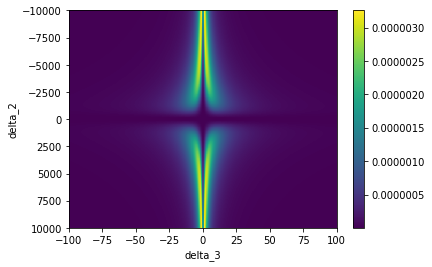

In [24]:
# plt.subplot(1,2,1)

delta2vals = np.linspace(-10000e6,10000e6,501)
delta3vals = np.linspace(-100e6,100e6,501)
coh = np.zeros((len(delta2vals),len(delta3vals)))
#coh2 = np.zeros((len(delta2vals),len(delta3vals)))

for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        coh[ii,jj] = np.abs(steady_rho13(p))**2
#        coh2[ii,jj] = np.abs(steady_rho13(p))**2

#plt.subplot(1,2,1)        
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar()


### more "understandable"  behavior
#### Driving optical pump hard, driving microwaves weakly


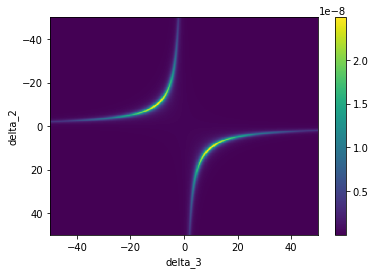

In [25]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 10e6
p['omegam'] = 1e3
p['g'] = 0.


delta2vals = np.linspace(-50e6,50e6,505)
delta3vals = np.linspace(-50e6,50e6,505)
coh = np.zeros((len(delta2vals),len(delta3vals)))


for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        coh[ii,jj] = np.abs(steady_rho13(p))**2
        
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar();


#### Driving optics weakly, microwaves hard

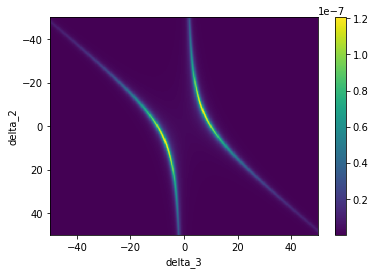

In [26]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e3
p['omegam'] = 10e6
p['g'] = 0.


delta2vals = np.linspace(-50e6,50e6,501)
delta3vals = np.linspace(-50e6,50e6,501)
coh = np.zeros((len(delta2vals),len(delta3vals)))
for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        coh[ii,jj] = np.abs(steady_rho13(p))**2
        
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar();

#### driving both weakly

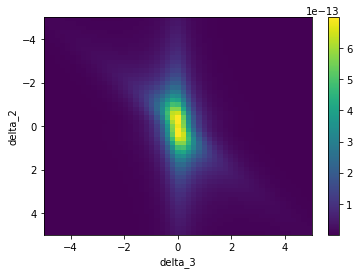

In [27]:
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e3
p['omegam'] = 1e3
p['g'] = 0.


delta2vals = np.linspace(-5e6,5e6,51)
delta3vals = np.linspace(-5e6,5e6,51)
coh = np.zeros((len(delta2vals),len(delta3vals)))
for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        coh[ii,jj] = np.abs(steady_rho13(p))**2
        
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar();

### Try out integration over inhomogeneous line

In [105]:
#some default parameters
df = 200e3
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 10e3
p['omegam'] = 10e6
p['g'] = 0.

p['mean_delta2']=0
p['sd_delta2']=20e6/2.355 #2.355 to turn FWHM into sigma
p['mean_delta3']=0
p['sd_delta3']=300e6/2.355

m2=p['mean_delta2']
sd2=p['sd_delta2']
m3=p['mean_delta3']
sd3=p['sd_delta3']

ndelta2 = int(6*sd2/df)
ndelta3 = int(6*sd3/df)


delta2vals = np.linspace(-3,3,ndelta2)*sd2+m2
delta3vals = np.linspace(-3,3,ndelta3)*sd3+m3

coh = np.zeros((len(delta2vals),len(delta3vals)),dtype='complex128')
for ii in range(len(delta2vals)):
    for jj in range(len(delta3vals)):
        p['delta2']=delta2vals[ii]
        p['delta3']=delta3vals[jj]
        gaussie = 1/(2*np.pi*sd3*sd2) * np.exp(-(p['delta2']-m2)**2/(2*sd2*sd2)-(p['delta3']-m3)**2/(2*sd3*sd3))            
        coh[ii,jj] = steady_rho13(p) * gaussie

s1 = sum(sum(coh))*df*df
print(s1)

(1.6973584866503856e-06+4.489353121858751e-22j)


In [106]:
ensemble_steady_rho13(p,400e3)

(1.690003828019794e-06+4.5184298210904305e-21j)

In [107]:
ensemble_steady_rho13(p,200e3)


(1.6973584866503921e-06+9.610506515572468e-22j)

In [117]:
%time ensemble_steady_rho13(p,100e3)

3890287
CPU times: user 3.77 s, sys: 7.78 ms, total: 3.78 s
Wall time: 3.77 s


(1.7042683768438422e-06+2.552342141740294e-21j)

In [115]:
3.77/3890287

In [102]:
list(map( lambda x: ensemble_steady_rho13(p,x).real, [800e3,400e3,200e3,100e3]))

In [110]:
list(map( lambda x: ensemble_steady_rho13(p,x).real, [800e3,400e3,200e3,100e3,50e3]))

In [111]:
%time ensemble_steady_rho13(p,100e3)

CPU times: user 3.73 s, sys: 19.5 ms, total: 3.75 s
Wall time: 3.75 s


(1.7042683768438422e-06+2.552342141740294e-21j)